# Image regoistration, tests from experimental data

In [1]:
import numpy as np
from pathlib import Path
import scipy.io as sio
import imageio
import cv2

from skimage import data, draw
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from spyrit.misc.disp import *
from spyrit.misc.metrics import *

## Loading data from the HSPC and RGB camera. 

In [2]:
data_root = "data"
rgb_img_file = Path(data_root) / ('test_cam.png')
f_r = cv2.imread('data/test_cam.png')
print(f_r.shape)

(2076, 3088, 3)


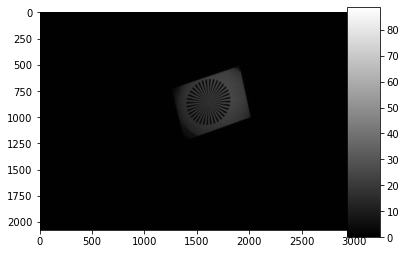

In [3]:
imagesc(f_r)

In [2]:
f_r = cv2.cvtColor(f_r, cv2.COLOR_BGR2GRAY)
f_r = f_r[600:1100,1350:1850];
f_r = cv2.resize(f_r, (64,64), interpolation = cv2.INTER_AREA);
f_r = f_r.astype(np.float32)
f_r = 255*(f_r-np.amin(f_r))/(np.amax(f_r)-np.amin(f_r))
# f_r = cv2.resize(f_r, (3000,3000), interpolation = cv2.INTER_AREA)

(2076, 3088, 3)


In [3]:
f_r.shape

(64, 64)

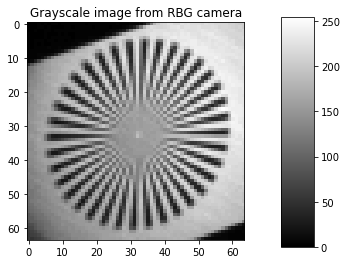

In [4]:
imagesc(f_r, "Grayscale image from RBG camera")

In [5]:
x = np.load("data/test_starsector_two_lens_f50_f25_MO_x10_red_fibre_had_reco.npz", mmap_mode='r')
# for k in x.files:
#     print(k);
f_h = x["arr_0"];
f_h = np.sum(f_h, axis = 2)
f_h = 255*(f_h-np.amin(f_h))/(np.amax(f_h)-np.amin(f_h))
# f_h = cv2.resize(f_h, (3000,3000), interpolation = cv2.INTER_AREA)

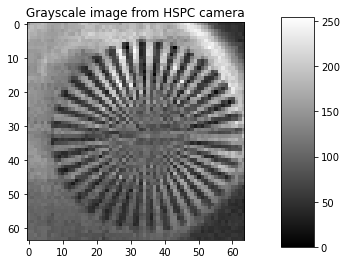

In [6]:
imagesc(f_h, "Grayscale image from HSPC camera")

In [7]:
# n = np.prod(f_h.shape)
# N = np.prod(f_r.shape)
# f = np.reshape(f_h, (n, 1));
# F = np.reshape(f_r, (N, 1));
# A = np.zeros((n,N));

## Testing iterative methods

Assuming the transform is $\mathbf{Af}_{\text{RGB}} = \mathbf{f}_{\text{SPC}}$, we minimise $\mathbf{A}^* = \text{argmin}_{\mathbf{A}} \|\mathbf{Af}_{\text{RGB}} = \mathbf{f}_{\text{SPC}}\|^2_2$.

Doing a gradient descent, we get the following algorithm :

$$\mathbf{A}^{(k)} = \mathbf{A}^{(k-1)} - 2 \tau ((\mathbf{A}^{(k-1)}\mathbf{f}_{\text{RGB}})\mathbf{f}_{\text{RGB}}^\top-\mathbf{A}^{(k-1)}\odot(\mathbf{f}_{\text{SPC}}\mathbf{f}_{\text{RGB}}^\top)) $$

Too high dimension!!! Doesn't work - Causes crash.

In [8]:
# Iterative estimation - minimisation of A*  = min_A \|f-AF\|^2_2
# (Doesn't work - requires too much memory)
# tau = 0.5;
# n_iter = 2;
# for i in range(n_iter):
#     print("i = "+str(i));
#     corr_1 = np.dot(np.dot(A,F), np.transpose(F));
#     print("Corr 1 done!");
#     corr_2 = np.multiply(A,np.dot(f, np.transpose(F)));
#     print("Corr 2 done!");
#     A = A - 2*tau*(corr_1-corr_2);

## Key points and searching for Homography 
We will use the ORB descriptor to find key points.

With those key points, we wish to find a 3D matrix H such that (see [link](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html), and this other [link](https://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf) for more details on homographies).
$$\begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \mathbf{H} \begin{bmatrix} p \\ q \\ 1 \end{bmatrix},$$
where $(x,y)$ are the coordinates of the original image, and $(p,q)$ are the coordinates of the image we wish to register.
It allows to account for translations, rotations, and scaling of the camera in the 3D plane. This is exactly what we want for our problem as it's mostly a rotation, translation and scaling of the camera...
Once the key points are chosen, we can use the RANSAC algorithm (see [link](https://en.wikipedia.org/wiki/Random_sample_consensus) for more details) to match the key points.


PS : A random idea would be to consider the actual 3D plane problem and compute the homography ourselves - needs skills with 3D geometry, so may require some work in that regard!

In [9]:
def alignImages(im1, im2, gray=False, match_root = "", MAX_FEATURES = 500, GOOD_MATCH_PERCENT = 0.5):
  # Convert images to grayscale
    if not(gray):
        im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY);
        im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY);
    else:
        im1Gray = im1;
        im2Gray = im2;
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray.astype(np.uint8), None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray.astype(np.uint8), None)
 
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches = list(matches)
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # # Draw top matches
    if match_root:
        imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None);
        cv2.imwrite(match_root, imMatches);

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32);
    points2 = np.zeros((len(matches), 2), dtype=np.float32);

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt;
        points2[i, :] = keypoints2[match.trainIdx].pt;

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC);

    # Use homography
    height, width, channels = im2.shape;
    im1Reg = cv2.warpPerspective(im1, h, (width, height));
    return im1Reg, h;


In [10]:
# Read reference image
# refFilename = "data/form.jpg"
refFilename = "data/ref.jpg"
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
imFilename = "data/align.jpg"
print("Reading image to align : ", imFilename);
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg.
# The estimated homography will be stored in h.
imReg, h = alignImages(im, imReference)

# Write aligned image to disk.
outFilename = "data/aligned_img.jpg"
print("Saving aligned image : ", outFilename);
cv2.imwrite(outFilename, imReg)

# Print estimated homography
print("Estimated homography : \n",  h)

Reading reference image :  data/ref.jpg
Reading image to align :  data/align.jpg
Aligning images ...
Saving aligned image :  data/aligned_img.jpg
Estimated homography : 
 [[-4.66065490e-01 -3.73589594e-01  1.52895307e+03]
 [-4.15552231e-01 -3.33015864e-01  1.36310236e+03]
 [-3.04832888e-04 -2.44325654e-04  1.00000000e+00]]


Does not work for our image --> does not manage to capture key points (apparently it is normal, because OpenCV cannot find enough features in objects with too many symetries (see this [link](https://stackoverflow.com/questions/66876495/opencv-homography-gives-error-the-input-arrays-should-have-at-least), and this other [link](https://stackoverflow.com/questions/67561760/orbs-detectandcompute-returns-none-for-a-slightly-different-image))). They recommend trying optical flow methods to try to do the registration.

In [11]:
# print("Aligning images ...")
# # Registered image will be resotred in imReg.
# # The estimated homography will be stored in h.
# imReg, h = alignImages(f_r, f_h, gray = True)

# # Write aligned image to disk.
# outFilename = "data/aligned_img.jpg"
# print("Saving aligned image : ", outFilename);
# imagesc(imReg)

# # Print estimated homography
# print("Estimated homography : \n",  h)

## Using Lucas Kanade optical flow algorithm to find key points.

In [12]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 3,
                       blockSize = 3)

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (5, 5),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))



def checkedTrace(img0, img1, p0, lk_params, back_threshold = 1.0):
    p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params);
    p0r, st, err = cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params);
    d = abs(p0-p0r).reshape(-1, 2).max(-1);
    # print(d)
    status = d < back_threshold;
    return p1, status;

def LK_homography(im1, im2, feature_params, lk_params, back_threshold = 1.0, gray = False):
    if not(gray):
        im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY);
        im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY);
    else:
        im1Gray = im1;
        im2Gray = im2;
    p0 = cv2.goodFeaturesToTrack(im1Gray.astype(np.uint8), **feature_params);
    p2, trace_status = checkedTrace(im1Gray.astype(np.uint8), im2Gray.astype(np.uint8), p0, lk_params,  back_threshold);
    p1 = p2[trace_status].copy();
    p0 = p0[trace_status].copy();
    print(p0)
    print(p1)
    H, status = cv2.findHomography(p0, p1, cv2.RANSAC, 10.0);
    return H;

def warp_from_homography(im1Gray, H):
    h, w = im1Gray.shape[:2];
    overlay = cv2.warpPerspective(im1Gray, H, (w, h));
    return overlay;


In [13]:
H = LK_homography(f_h, f_r, feature_params, lk_params,  back_threshold = 40.0, gray = True);

[[[24.  7.]]

 [[55. 15.]]

 [[58. 19.]]

 [[51. 11.]]

 [[38.  6.]]

 [[43.  7.]]]
[[[ 3.03196793e+01  3.51400948e+01]]

 [[ 2.64887276e+01 -1.25807705e+01]]

 [[ 3.37494545e+01  6.00374937e-02]]

 [[ 5.57848129e+01  3.14768486e+01]]

 [[ 4.56318855e-02 -2.69897156e+01]]

 [[ 5.27794952e+01  4.58834763e+01]]]


In [14]:
H

array([[ 6.47671649e-01,  2.35078680e+00, -3.87079890e+01],
       [ 2.70596616e+00, -3.78151081e+00, -8.50199099e+01],
       [-4.62577016e-02,  1.56447673e-01,  1.00000000e+00]])

In [15]:
f_h_bis = warp_from_homography(f_h, H)

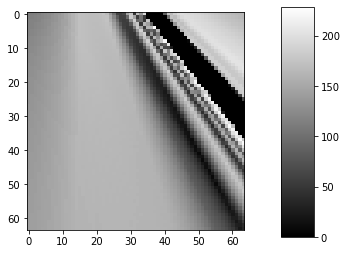

In [16]:
imagesc(f_h_bis) # On voit l'échec de la méthode!

Does not work well at all!! Seems like same as ORB, our descriptors do not make a lot of sense here...

## Using Dual TV-L1 optical flow estimation.
The optical flow is obtained with an inverse problem approach where we minimise the optical flow equation (Horn-Shunk), with L1-TV constraints.
Finally, we recover the image by transforming 
$$\mathbf{f}_{\text{SPC}}^*(x,y) = \mathbf{f}_{\text{RGB}}(x+u(x,y),y+v(x,y))$$

In [17]:
optical_flow = cv2.optflow.DualTVL1OpticalFlow_create(tau=1);
flow = optical_flow.calc(f_h.astype(np.uint8), f_r.astype(np.uint8), None);

In [18]:
flow.shape

(64, 64, 2)

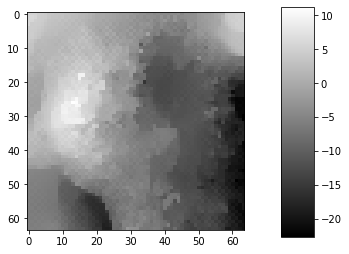

In [19]:
imagesc(flow[:,:,0])

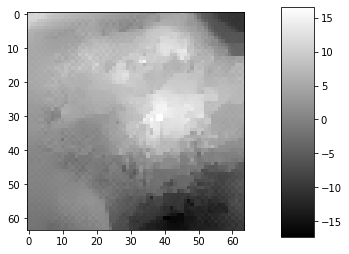

In [20]:
imagesc(flow[:,:,1])

In [21]:
flow_bis = np.round(optical_flow.getTau()*flow)

In [22]:
x = np.array(range(64));
y = np.array(range(64));
X,Y = np.meshgrid(x,y)
X_grid = X+flow_bis[:,:,0];
Y_grid = Y+flow_bis[:,:,1];

In [23]:
X_grid[X_grid>63] = 63;
X_grid[X_grid<0] = 0;
Y_grid[Y_grid>63] = 63;
Y_grid[Y_grid<0] = 0;

In [24]:
f_r_bis = f_r[X_grid.astype(int),Y_grid.astype(int)]

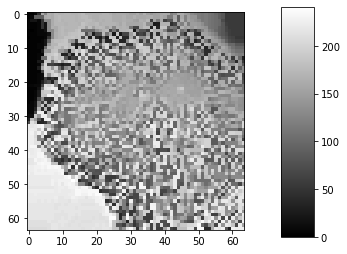

In [25]:
imagesc(f_r_bis)  # ECHEC AUSSI!!!

Was also a failure... it is probably due to the constraints of the algorithm : low movements, AND smooth flows...

## Giving up on automatic descriptors, and doing it by hand...the poor man's registration...
We place the points manually, and then we look for the homography.

### Visualisation of the different points

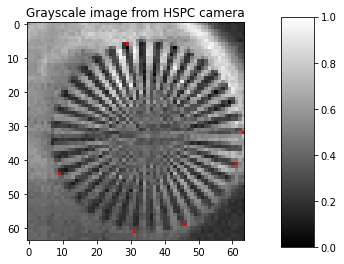

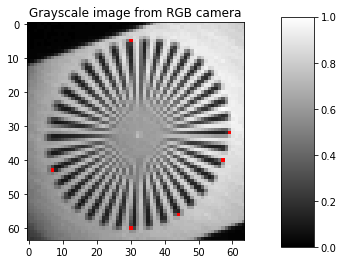

In [70]:
f_h_test = np.zeros((64,64,3));
f_h_test[:,:,0] = f_h/255;
f_h_test[:,:,1] = f_h/255;
f_h_test[:,:,2] = f_h/255;
f_h_test[6,29,:] = np.array([1,0,0])
f_h_test[44,9,:] = np.array([1,0,0])
f_h_test[41,61,:] = np.array([1,0,0])
f_h_test[59,46,:] = np.array([1,0,0])
f_h_test[32,63,:] = np.array([1,0,0])
f_h_test[32,63,:] = np.array([1,0,0])
f_h_test[61,31,:] = np.array([1,0,0])
# f_h_test[12,15,:] = np.array([1,0,0])
# f_h_test[14,56,:] = np.array([1,0,0])
# f_h_test[25,7,:] = np.array([1,0,0])


f_r_test = np.zeros((64,64,3));
f_r_test[:,:,0] = f_r/255;
f_r_test[:,:,1] = f_r/255;
f_r_test[:,:,2] = f_r/255;
f_r_test[5,30,:] = np.array([1,0,0])
f_r_test[43,7,:] = np.array([1,0,0])
f_r_test[40,57,:] = np.array([1,0,0])
f_r_test[56,44,:] = np.array([1,0,0])
f_r_test[32,59,:] = np.array([1,0,0])
f_r_test[60,30,:] = np.array([1,0,0])
# f_r_test[11,16,:] = np.array([1,0,0])
# f_r_test[15,54,:] = np.array([1,0,0])
# f_r_test[24,7,:] = np.array([1,0,0])

imagesc(f_h_test, "Grayscale image from HSPC camera")
imagesc(f_r_test, "Grayscale image from RGB camera")

In [71]:
pts_i = [[29,6], [9,44], [61,41], [46,59], [63,32],[31,61]];
pts_j = [[30,5], [7,43], [57,40], [44,56], [59,32], [30,60]];

# pts_i = [[29,6], [9,44], [61,41], [46,59], [63,32],[31,61],[15,12],[56,14],[7,25]];
# pts_j = [[30,5], [7,43], [57,40], [44,56], [59,32], [30,60],[16,11],[54,15],[7,24]];

In [72]:
# A = get_matrix(pts_i, pts_j);
H, status = cv2.findHomography(np.array(pts_j), np.array(pts_i), cv2.RANSAC, 10.0);


In [73]:
H

array([[ 7.77266191e-01,  2.49943967e-02,  2.24754736e+00],
       [-1.49585344e-01,  8.80521605e-01,  5.42964243e+00],
       [-3.67985330e-03, -2.54871723e-04,  1.00000000e+00]])

In [74]:
f_r_bis = warp_from_homography(f_r, H)

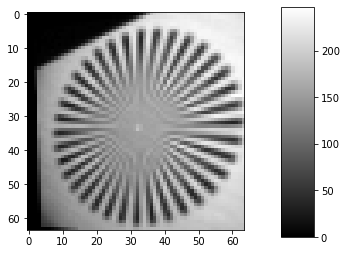

In [75]:
imagesc(f_r_bis)

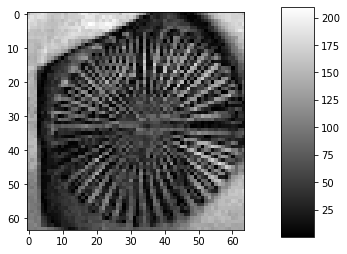

In [76]:
imagesc(np.abs(f_r_bis-f_h))

In [77]:
np.amax(np.abs(f_r_bis-f_h))

209.94416288533805

In [78]:
(np.mean(f_h)-np.mean(np.abs(f_r_bis-f_h)))/np.mean(f_h)

0.3899041612721402

Pas trop mauvais résultat! On retiendra ceci dit les déformations aux bords (qu'il faudra surement chercher à ignorer par le biais de la matrice de covariance (leur donner un poids irréaliste comparé au reste de l'image).

In [4]:
import spas

ModuleNotFoundError: No module named 'winreg'